## <ins>Introduction</ins>

This project is about Neural style transfer for creating artistic images from regular images.

Style transfer is an optimization technique used to take two images — a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.


### Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing import image as image_lib

import IPython.display as display

from PIL import Image
import functools

#### Path to images and styles

In [2]:
image_path = '/content/drive/My Drive/Style transfer artwork/images'
style_path = '/content/drive/My Drive/Style transfer artwork/styles'

## Visualizing some sample images and styles

In [3]:
import cv2
import os

# Function to load images from folder
def load_images(folder):
  
  images = [] #Empty list to store the images

  for filename in os.listdir(folder):

    img = cv2.imread(os.path.join(folder,filename))

    # Keeping the color of images to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if img is not None:

      images.append(img)

  # Preprocessing the images
  images = np.array(images)# Converting image list to numpy array

  images = images/255 #Scaling the images.
  """
  The pixel value of each image ranges between 0 and 255
  Dividing each image by 255 will scale the values between 0 and 1. 
  This is also known as normalization.

  """

  return images

#### Loading the images and styles

In [4]:
images = load_images(image_path)

styles = load_images(style_path)

#### Visualizing some of the images 

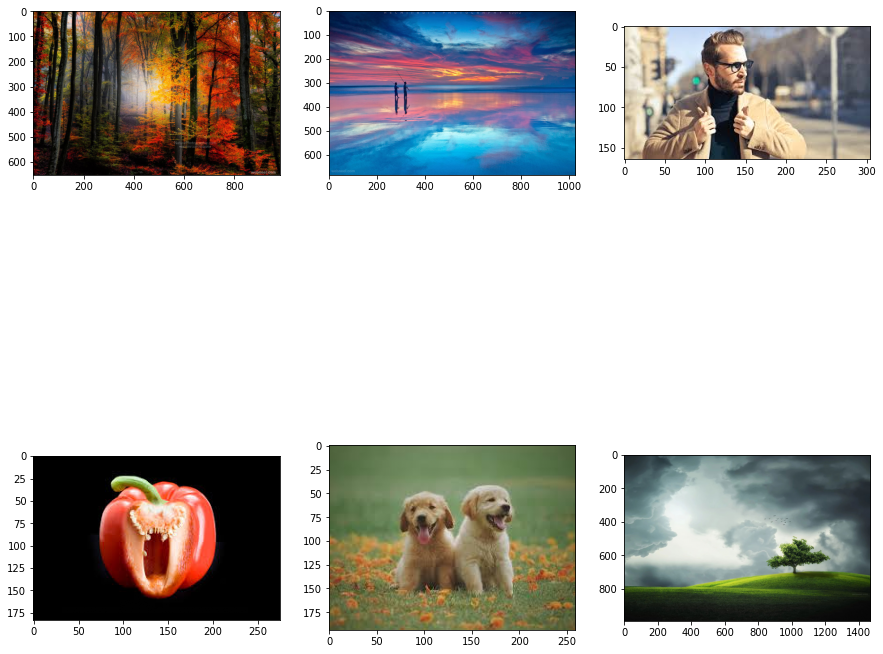

In [5]:
import random

plt.figure(figsize = (15,15))

for i in range(1,7):

  x = random.randint(0,len(images)-1)

  plt.subplot(2,3,i)
  plt.imshow(images[x])


#### Visualizing some of the styles

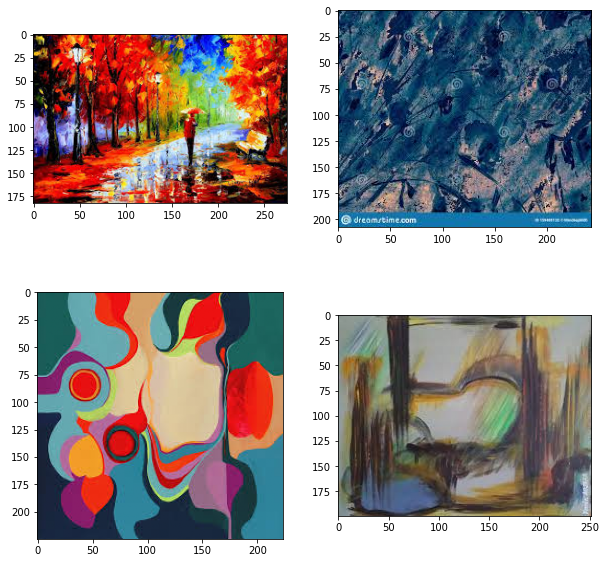

In [7]:
import random

plt.figure(figsize = (10,10))

for i in range(1,5):

  x = random.randint(0,len(styles)-1)

  plt.subplot(2,2,i)
  plt.imshow(styles[x])

#####  

**Let's select a single image and style.**

We'll define a function that will load the image and style in the required format.

In [8]:
def load_img(path_to_img):

  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)#Resizing the image with new scales
  
  img =image_lib.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

Function to display the image and style

In [9]:
def imshow(img, title=None):

  # Remove the batch dimension
  pic = np.squeeze(img, axis=0)

  # Normalize for display 
  pic = pic.astype('uint8')
  
  plt.imshow(pic)
  if title is not None:
    plt.title(title)
  plt.imshow(pic)

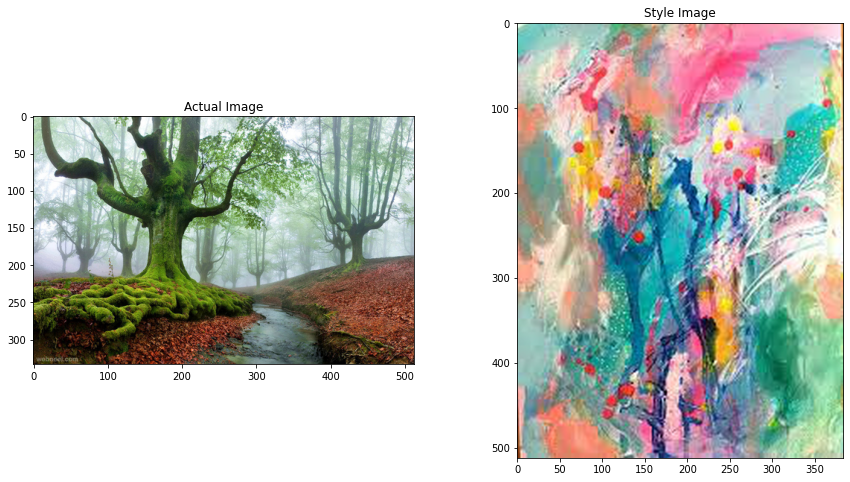

In [10]:
#Specify the file paths here
#I used google colab so files are fetched form my drive
content_image_path = '/content/drive/My Drive/Style transfer artwork/images/12-nature-photography-tree-pixelecta.jpg'
style_image_path = '/content/drive/My Drive/Style transfer artwork/styles/download.jfif'

content_img = load_img(content_image_path)
style_img = load_img(style_image_path)

plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
imshow(content_img, 'Actual Image')

plt.subplot(1,2,2)
imshow(style_img, 'Style Image')

#####   

## <ins>VGG Model</ins>

For this project, we are going to use the VGG19 model.

#### What is VGG19?

VGGNet is invented by VGG (Visual Geometry Group) from University of Oxford.

VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

##### Model architecture:
#  
<img src = "https://user-images.githubusercontent.com/24521991/33163607-453dab62-d06a-11e7-803d-22be312a13eb.png" />



We will use the pretrained  vgg19 model from applications in keras package.

To understand how the model actually looks like in tensoflow or you want to build in from scratch, visit [here](https://gist.github.com/baraldilorenzo/8d096f48a1be4a2d660d)

In [11]:
from tensorflow.keras.applications import VGG19

#Loading the vgg19 model without the classification head

vgg = VGG19(include_top = False, weights = 'imagenet')

#Getting the layer names
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The intermediate layers of this model will be used for further processing.

#### Why intermediate layers?

According to the original [paper](https://arxiv.org/pdf/1409.1556.pdf), the intermediate outputs within the pretrained image classification network defines style and content representations.



In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

We need the content of our image to be prevalant over the style.

The lower layers of the model learns about the low level details such as shaders, textures, edge details etc.

Wheras the higher layers learns the actual content of an image such as the face, position of eyes etc.

## Building the Model

This function will load the VGG19 model and access the intermediate layers. 
These layers will then be used to create a new model that will take input image and return the outputs from these intermediate layers from the VGG model.

In [13]:
def Model():

  #Loading the vgg19 model
  vgg = VGG19(include_top = False, weights = 'imagenet')

  #Since this model is already trained, we don't need to train it again.
  vgg.trainable = False

  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  output = style_outputs + content_outputs

  # Creating model
  model = tf.keras.Model([vgg.input], output)

  return model

Now, we need to calculate a gram matrix to calculate the style.

#### **What is gram matrix?**

[**Gram matrix**](https://medium.com/@cdsjatin/tell-me-again-how-much-gram-is-in-the-matrix-71652095b2c7#:~:text=Gram%20matrix%20is%20simply%20the,computed%20using%20the%20gram%20matrix.) is simply the matrix of the inner product of each vector and its corresponding vectors in same.

In deep learning , while style transferring the loss function is computed using the gram matrix.

The formula can be represented as:

<img src = "https://miro.medium.com/max/304/1*cb1VrP8Gnx7lf7uZHj-wSw.png" >

<img src = "https://miro.medium.com/max/2026/1*eAcdLzoo_8nnv1g3NTTPzg.png" >

In [14]:
def gram_matrix(input_tensor):

   # We make the image channels first 
  channels = int(input_tensor.shape[-1])

  a = tf.reshape(input_tensor, [-1, channels])

  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)

  return gram / tf.cast(n, tf.float32)

### Content loss and style loss

**Content loss:**
We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply model(input_image)!) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed.

**Style loss:**
Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the base input image and the style image. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs.

In [15]:
# Defining Content loss
def content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

# Defining Style loss
def style_loss(base_style, gram_target):

  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

The following function will compute the total loss.
  
  Arguments:

  model: The model that will give us access to the intermediate layers
  
  loss_weights: The weights of each contribution of each loss function. 
    (style weight, content weight, and total variation weight)

  image: Our initial base image. This image is what we are updating with 
    our optimization process. We apply the gradients wrt the loss we are 
    calculating to this image.

  gram_style_features: Precomputed gram matrices corresponding to the 
    defined style layers of interest.

  content_features: Precomputed outputs from defined content layers of 
    interest.

In [16]:
def compute_loss(model, loss_weights, image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
  
  # Feed our image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)

  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)

  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

#### Defining a model that will return style and content features

This function will simply load and preprocess both the content and style 
images from their path. Then it will feed them through the network to obtain
the outputs of the intermediate layers. 

In [17]:
def feature_representations(model, content_path, style_path):

  # Loading and preprocessing images
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]

  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

  return style_features, content_features

Let's define a function to scale images

In [18]:
def scale(image, clip_value_min, clip_value_max):

  return tf.clip_by_value(image, clip_value_min=clip_value_min, clip_value_max=clip_value_max)

Now , we have to define a tensorflow function that will apply style and update the image.

We will use tf.GradientTape()

**Finally a function to compute the gradients**

In [19]:
def compute_grads(config):

  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**config)

  # Compute gradients wrt input image
  total_loss = all_loss[0]

  return tape.gradient(total_loss, config['image']), all_loss

The following function will be used to process the converted image for displaying further.

In [20]:
def tensor_to_image(processed_img):

  x = processed_img.copy()

  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to converting image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to processing image")

  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Visit [here](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.fromarray) for more details about PIL.Image.fromarray

#### Preprocessing image function

In [21]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

### Training the model

In [22]:
import time

def style_transfer(content_image_path, style_image_path, num_iterations=1000, content_weight=1e4, style_weight=1e-2): 

  # We don't want to train any layers of our model, so we set
  # trainable to false. 
  model = Model()

  for layer in model.layers:
    layer.trainable = False


  # Preprocessing content image
  image = load_and_process_img(content_image_path)
  image = tf.Variable(image, dtype=tf.float32)


  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = feature_representations(model, content_image_path, style_image_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  

  # Create our optimizer
  opt = tf.keras.optimizers.Adam(lr = 5, beta_1=0.99, epsilon=1e-1)
  
  # Variables to store our best result
  best_loss, best_img = float('inf'), None
  
  # Creating config dictionary
  loss_weights = (style_weight, content_weight)

  config = {
      'model': model,
      'loss_weights': loss_weights,
      'image': image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  
  """
  VGG networks are trained on image with each channel 
  normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.
  
  """
  normalized_means = np.array([103.939, 116.779, 123.68])
  min_values = -normalized_means
  max_values = 255 - normalized_means  

  import time
  
  start_time = time.time()
  global_start = time.time()

  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)

  imgs = [] #Empty array to store the all the converted images after every 100 iteration

  for i in range(num_iterations):

    # Computing the gradients
    grads, all_loss = compute_grads(config)

    # Collecting all kinds of losses
    loss, style_score, content_score = all_loss

    # Applying the gradients to update the image
    opt.apply_gradients([(grads, image)])

    image.assign(scale(image, min_values, max_values))
    #print(".", end='')

    if loss < best_loss:

      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = tensor_to_image(image.numpy())

  
    # To display the converted image after every 100 iterations
    if i % display_interval== 0:

      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = image.numpy()
      plot_img = tensor_to_image(plot_img)

      imgs.append(plot_img)
      
      display.clear_output(wait=True)
      display.display_png(Image.fromarray(plot_img))

      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))

  display.clear_output(wait=True)

  plt.figure(figsize=(14,4))
  
  for i,img in enumerate(imgs):

    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

  return best_img, best_loss

Finally, let's define a function that will plot all three images, i.e, content image, style image, and converted image.

In [23]:
def compare(best_image, content_path, style_path):

  content_img = load_img(content_path)
  style_img = load_img(style_path)

  plt.figure(figsize = (12,10))
  plt.subplot(1,2,1)
  imshow(content_img, 'Actual Image')

  plt.subplot(1,2,2)
  imshow(style_img, 'Style Image')

  #plt.subplot(1,3,3)
  plt.figure(figsize=(8, 8))
  plt.imshow(best_image)
  plt.title('Stylized Image')
  plt.show()

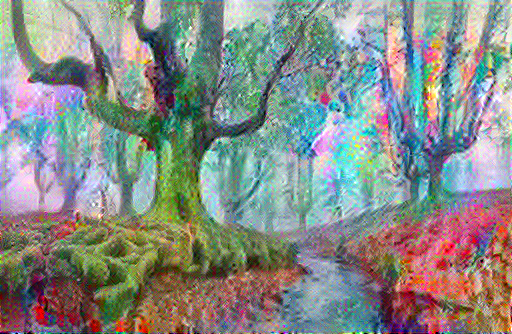

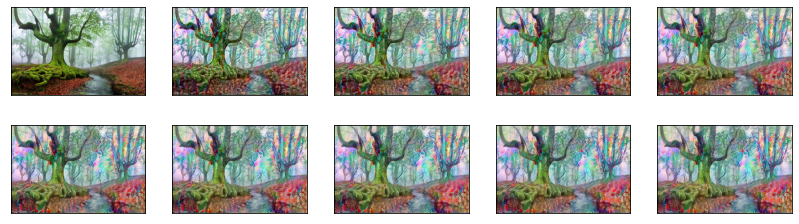

In [24]:
content_image_path = '/content/drive/My Drive/Style transfer artwork/images/12-nature-photography-tree-pixelecta.jpg'
style_image_path = '/content/drive/My Drive/Style transfer artwork/styles/download.jfif'

best_image, best_loss = style_transfer(content_image_path, style_image_path, num_iterations=1000)

display.display_png(Image.fromarray(best_image))

**The converted image actually took up a lot of the style details and looks pretty cool too.**

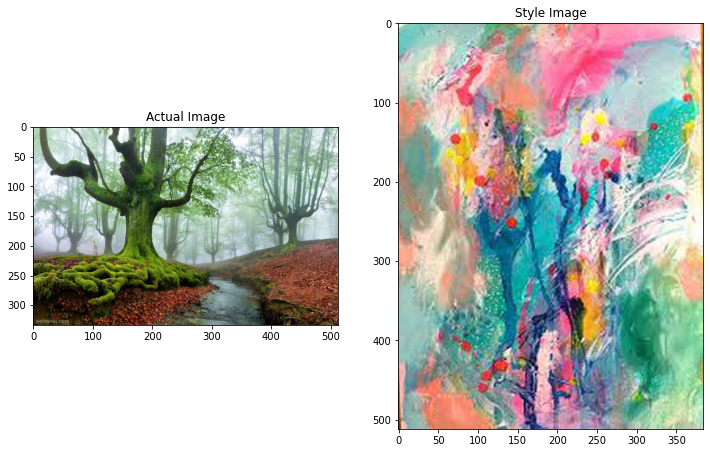

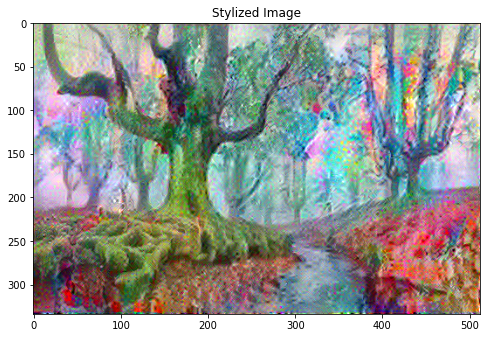

In [25]:
compare(best_image, content_image_path, style_image_path)

## Testing on one more image and style

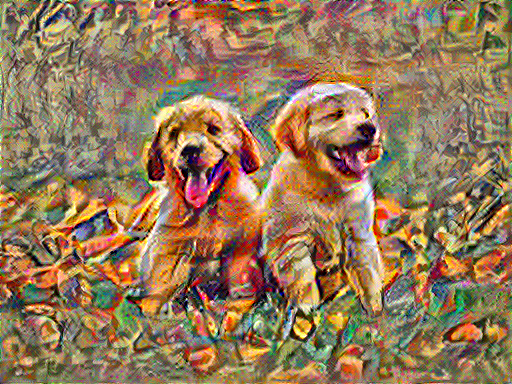

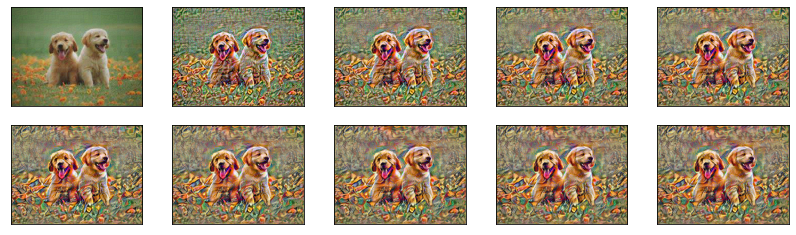

In [26]:
content_image_path = '/content/drive/My Drive/Style transfer artwork/images/download.jfif'
style_image_path = '/content/drive/My Drive/Style transfer artwork/styles/images (1).jfif'

best_image, best_loss = style_transfer(content_image_path, style_image_path, num_iterations=1000)

display.display_png(Image.fromarray(best_image))


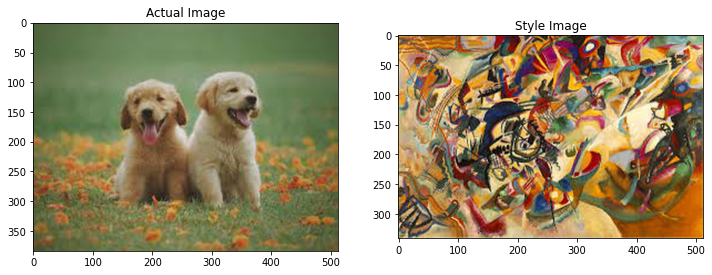

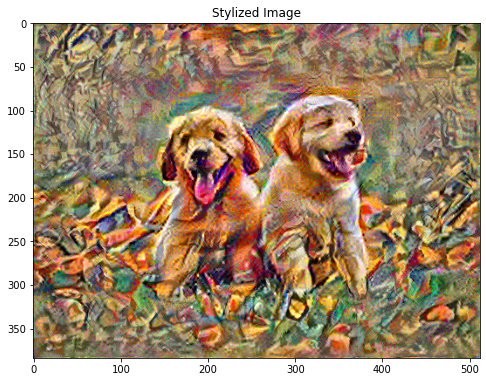

In [27]:

#Displaying comparison
compare(best_image, content_image_path, style_image_path)